In [1]:
sc.uninstall_package("pip")
sc.install_pypi_package("pip==22.2.2")
sc.install_pypi_package("opencv-python")
sc.install_pypi_package("numpy")
sc.install_pypi_package("matplotlib")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1694420651016_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Uninstalling pip-9.0.1:
  Successfully uninstalled pip-9.0.1

  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)

  Using cached opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)


  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Using cached packaging-23.1-py3-none-any.whl (48 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.5-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)
  Using cached Pillow-9.5.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached typing_extensions-4.7.1-py3-none-any.whl (33 kB)




[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: /tmp/1694425994829-0/bin/python -m pip install --

In [2]:
import math
from itertools import product
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, asc

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
def convert_deg_to_num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0**zoom
    x_tile = int((lon_deg + 180.0) / 360.0 * n)
    y_tile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return(x_tile, y_tile)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
def convert_num_to_deg(x_tile, y_tile, zoom):
    n = 2.0**zoom
    lon_deg = x_tile / n* 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * y_tile / n)))
    lat_deg = math.degrees(lat_rad)
    return(lat_deg, lon_deg)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
def plot_img(img):
    plt.clf()
    plt.gray()
    plt.imshow(img)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [87]:
def plot_map(combo, x_interval, y_interval):
    columns = [np.concatenate(combo[i*y_interval : (i+1)*y_interval], axis = 0) for i in range(x_interval - 1)]
    mapp = np.concatenate(columns, axis = 1)
    plt.clf()
    plt.axis('off')
    plt.imshow(mapp)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [88]:
def get_height(data):
    (B, G, R) = cv2.split(data)
    a = (R * 256.0 + G + B/256.0) - 32768.0
    a = np.where(a > 0, a, 0)
    return a

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
def get_tiles_url(zoom, lat_west, lon_north, lat_east, lon_south):
    min_lat, min_lon = min(lat_west, lat_east), min(lon_north, lon_south)
    max_lat, max_lon = max(lat_west, lat_east), max(lon_north, lon_south)
    x_min, y_min = convert_deg_to_num(max_lat, min_lon, zoom)
    x_max, y_max = convert_deg_to_num(min_lat, max_lon, zoom)
    tiles_url = []
    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            tiles_url.append((f"s3://elevation-tiles-prod//terrarium/{zoom}/{x}/{y}.png"))
    
    x_interval = (x_max - x_min) + 1
    y_interval = (y_max - y_min) + 1
    
    return tiles_url, x_interval, y_interval

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [144]:
def create_groups(data):
    rdd = spark.sparkContext.parallelize(data)
    means = rdd.map(lambda x: cv2.mean(x)).sortBy(lambda x: x[0]).collect()
    amount = len(means)
    groups = []
    """
    5 groups:
    0 -> 25%
    1 -> 25% - 45%
    2 -> 45% - 75%
    3 -> 75% - 90% 
    4 -> 90% - 100%
    """
    groups.append(means[int(90*amount/100)][0])
    groups.append(means[int(75*amount/100)][0])
    groups.append(means[int(45*amount/100)][0])
    groups.append(means[int(25*amount/100)][0])
    
    return groups

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [225]:
def process_map_view(array_in, groups):
    array = array_in
    array = np.where(array_in >= groups[0], 40, array)
    array = np.where((groups[0] > array_in) & (array_in >= groups[1]), 30, array)
    array = np.where((groups[1] > array_in) & (array_in >= groups[2]), 20, array)
    array = np.where((groups[2] > array_in) & (array_in >= groups[3]),  10, array)
    array = np.where((groups[3] > array_in),  0, array)    
    
    return array

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [226]:
def colour(data, groups):
    rdd = spark.sparkContext.parallelize(data)
    coloured_map = rdd.map(lambda x: process_map_view(x, groups)).collect()
    
    return coloured_map

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [227]:
def to_idx(file):
    output = int(file.split("/")[5])
    
    return output

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [228]:
def to_idy(file):
    output = file.split("/")[6]
    output = int(output.split(".")[0])
    
    return output

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [229]:
def main():
    EUROPA = (71.0, -32.0, 36.0, 45.0)
    
    data, x_interval, y_interval = get_tiles_url(5, *EUROPA)
    data_in_1 = spark.read.format("image").load(data)
    data_in_2 = data_in_1.select("image.origin", "image.data")
    
    new_idx = F.udf(to_idx, IntegerType())
    new_idy = F.udf(to_idy, IntegerType())
    
    data_in_2 = data_in_2.withColumn("idx", new_idx("origin"))
    data_in_2 = data_in_2.withColumn("idy", new_idy("origin"))
    data_in_2 = data_in_2.orderBy(col("idx").asc(), col("idy").asc())
    
    images = data_in_2.select("data")
    images = images.rdd.map(lambda img: np.reshape(img, (256,256,3)))
    images = images.map(get_height) 
    
    gradient_X = images.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 0, 1))
    gradient_Y = images.map(lambda img: cv2.Sobel(img, cv2.CV_64F, 1, 0))
    
    gradient_x = np.asarray(gradient_X.take(gradient_X.count()))
    gradient_y = np.asarray(gradient_Y.take(gradient_Y.count()))
    
    combined = np.sqrt(gradient_x**2 + gradient_y**2)
    groups = create_groups(combined)
    coloured_map = colour(combined, groups)
    
    plot_map(coloured_map, x_interval, y_interval)
    plt.imsave('europe_map.png', coloured_map)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

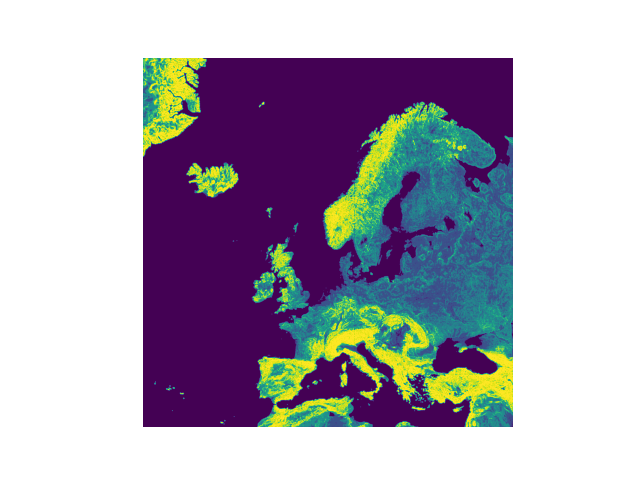

In [230]:
main()
%matplot plt